# Choose tutors. Choose proper tutors for math exam

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Получение данных

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
target = 'choose'

X_train = df_train.drop(columns=['Id'])
X_test = df_test.drop(columns=['Id'])

X_train.shape

(10000, 12)

### Разведывательный анализ данных (EDA)

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  float64
 1   years_of_experience  10000 non-null  float64
 2   lesson_price         10000 non-null  float64
 3   qualification        10000 non-null  float64
 4   physics              10000 non-null  float64
 5   chemistry            10000 non-null  float64
 6   biology              10000 non-null  float64
 7   english              10000 non-null  float64
 8   geography            10000 non-null  float64
 9   history              10000 non-null  float64
 10  mean_exam_points     10000 non-null  float64
 11  choose               10000 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [5]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10000.0,45.8009,8.030274,23.0,40.0,46.0,51.0,68.0
years_of_experience,10000.0,1.9748,1.766883,0.0,0.0,2.0,3.0,9.0
lesson_price,10000.0,1702.4400,523.789062,200.0,1300.0,1550.0,2150.0,3950.0
qualification,10000.0,1.7243,0.798845,1.0,1.0,2.0,2.0,4.0
physics,10000.0,0.3706,0.482990,0.0,0.0,0.0,1.0,1.0
chemistry,10000.0,0.1215,0.326724,0.0,0.0,0.0,0.0,1.0
biology,10000.0,0.1172,0.321675,0.0,0.0,0.0,0.0,1.0
english,10000.0,0.0591,0.235824,0.0,0.0,0.0,0.0,1.0
geography,10000.0,0.0277,0.164120,0.0,0.0,0.0,0.0,1.0
history,10000.0,0.0180,0.132958,0.0,0.0,0.0,0.0,1.0


In [6]:
X_train.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [7]:
# Сперва посмотрим на таргет
X_train[target].value_counts()

0    8891
1    1109
Name: choose, dtype: int64

Довольно сильный дисбаланс классов. Во первых, важно понимать природу такого дисбаланса. В данном случае, это естественно порядок вещей 0 в основном человек, работающий репетитором (даже начинающий), подходит для подготовки к экзамену по математике. В реальности, малое количество учеников меняют репетитора. Во-вторых, надо уточнить функцию ошибки. В данном случае испоьзуется `ROC AUC`, таким образом перебалансировка повысит качество обучения.

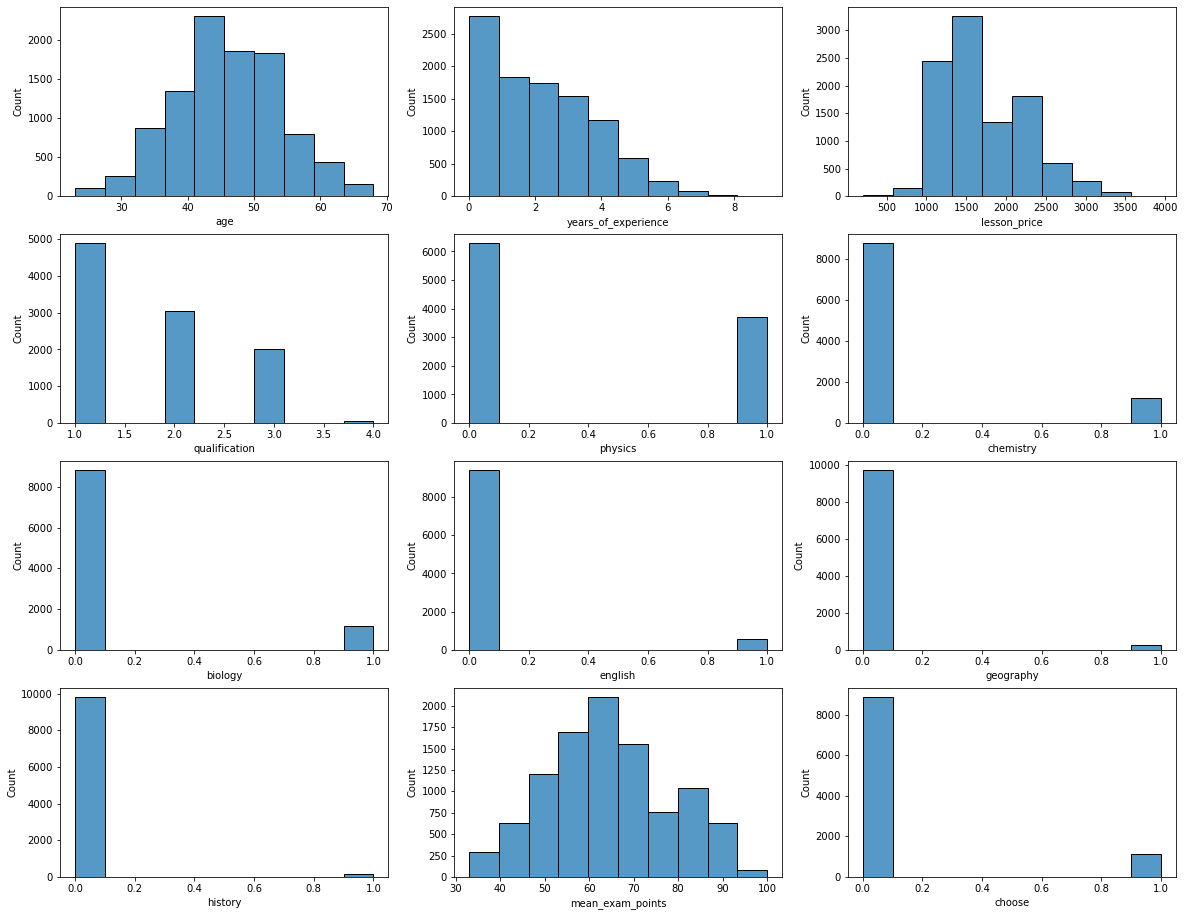

In [8]:
fig, ax = plt.subplots(4, 3, figsize=(20, 16))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        data_index = i*ax.shape[1]+j
        if data_index < len(X_train.columns):
            sns.histplot(X_train[X_train.columns[data_index]], ax=ax[i][j], bins=10)

Сразу видим несколько категориальных признаков. Распределение скалярных признаков в основном близкое к нормальному, выбросов не наблюдается. Также признаки необходимо масштабировать.

### Подготовка данных

In [9]:
def balance_df_by_target(df, target_name):
    '''Перебалансировка'''
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [10]:
df_balanced = balance_df_by_target(X_train, target)

y = df_balanced[target]
y.value_counts()

0    8891
1    8872
Name: choose, dtype: int64

In [11]:
features = ['years_of_experience', 'lesson_price', 'qualification', 'physics', 'chemistry', 'mean_exam_points']

X_train = df_balanced.drop(columns=[target])
X_train = X_train[features]
X_test = X_test[features]

In [12]:
def standardization(df):
    '''Функция стандартизации датафрейма'''
    df_st = df.copy()
    for column in df_st.columns:
        df_st[column] = (df_st[column] - df_st[column].mean()) / df_st[column].std()

    return df_st

In [13]:
X_train = standardization(X_train)
X_test = standardization(X_test)

X_train.head()

,years_of_experience,lesson_price,qualification,physics,chemistry,mean_exam_points
8413,2.175613,2.492868,1.507102,-0.967564,-0.434678,1.677355
5115,0.517605,-1.088250,-0.922948,-0.967564,2.300423,-1.331501
13013,-1.140404,-0.217167,0.292077,1.033465,-0.434678,0.211502
11469,-0.035065,-0.701102,0.292077,1.033465,-0.434678,-0.714300
10164,-1.140404,-0.410741,-0.922948,1.033465,2.300423,-0.251399


### Построение модели

In [14]:
np.random.seed(2)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        for j in range(n_samples):
            sample_index = np.random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

    return bootstrap


def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample))
    subsample = []

    np.random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample

In [15]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction

In [16]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [17]:
def quality(left_labels, right_labels, current_gini):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [18]:
def split(data, labels, index, t):

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [19]:
def find_best_split(data, labels):
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    subsample = get_subsample(n_features)

    for index in subsample:
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [20]:
def build_tree(data, labels, max_depth = 4, depth = 0):
    quality, t, index = find_best_split(data, labels)

    if depth < max_depth and t is not None:
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        true_branch = build_tree(true_data, true_labels, max_depth, depth=depth+1)
        false_branch = build_tree(false_data, false_labels, max_depth, depth=depth+1)
        return Node(index, t, true_branch, false_branch)
    else:
        return Leaf(data, labels)

In [21]:
def random_forest(data, labels, n_trees, max_depth = 4):
    data = data.to_numpy()
    labels = labels.to_numpy()
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, max_depth))

    return forest

In [22]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [23]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [24]:
def tree_vote(forest, data, proba = False):
    data = data.to_numpy()

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    predictions_per_object = list(zip(*predictions))

    voted_predictions = []

    if proba is True:
        for obj in predictions_per_object:
            class_0 = 0
            class_1 = 0
            for itm in obj:
                if itm == 0:
                    class_0 += 1
                else:
                    class_1 += 1
            probability = class_1 / (class_0 + class_1)
            voted_predictions.append(probability)
    else:
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

In [25]:
train_data, valid_data, train_labels, valid_labels = train_test_split(X_train,
                                                                    y,
                                                                    test_size = 0.3,
                                                                    random_state = 4)

In [51]:
forest = random_forest(train_data, train_labels, n_trees=20, max_depth=3)

In [52]:
train_answers = tree_vote(forest, train_data, proba=True)
train_score = roc_auc_score(train_labels, train_answers)
valid_answers = tree_vote(forest, valid_data, proba=True)
valid_score = roc_auc_score(valid_labels, valid_answers)
train_score, valid_score

(0.7838926273474572, 0.7723861125035539)

### Формирование предсказаний

In [53]:
test_answers = tree_vote(forest, X_test, proba=True)

preds = pd.DataFrame({
    'Id': df_test['Id'].copy(),
    'choose': test_answers
})
preds.head(10)

,Id,choose
0,10000,0.80
1,10001,0.95
2,10002,0.45
3,10003,0.80
4,10004,0.95
5,10005,0.95
6,10006,1.00
7,10007,1.00
8,10008,0.80
9,10009,0.95


### Сохранение предсказаний

In [54]:
preds.to_csv('./data/predictions.csv', index=False, encoding='utf-8', sep=',')